In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans


In [2]:
def plot_features(data, column_names, plot_name):
    plt.figure(figsize=(5,3))
    sns.violinplot(data=data, inner="quartile", palette="Set2")

    # Set labels
    plt.xticks(ticks=np.arange(len(column_names)), labels=column_names, rotation=30)
    plt.title(plot_name, fontsize=14)
    plt.ylabel("Value", fontsize=12)
    plt.xlabel("Features", fontsize=12)

    plt.tight_layout()
    plt.show()

In [3]:
### implementing the study of climate shift with kmeans
# 1. Stadardize.
# 2. PCA.
# 3. K-means.
# 4. Analysis of the start, end and duration of the seasons.

In [4]:
# Importing the data and creating the features
variables = [
'PRECTOTCORR',
# 'RH2M',
 'T2M',
 'T2M_MAX',
 'T2M_MIN',
 'WS2M']

features = []

doys = None
for variable in variables:
    #variable = variables[0]
    climate = pd.read_csv(fr'..\resources\{variable}\complete_dataset_{variable}.csv')



    new_feature = climate\
            .groupby(['YEAR','DOY'])\
            .mean()[climate.columns[-1]]\
            .to_list()
    if type(doys) == type(None) :
        doys = climate\
            .groupby(['YEAR','DOY'])\
            .mean().reset_index().DOY.to_numpy()
        years = climate\
            .groupby(['YEAR','DOY'])\
            .mean().reset_index().YEAR.to_numpy()

    features.append(new_feature)

features = np.array(features).T


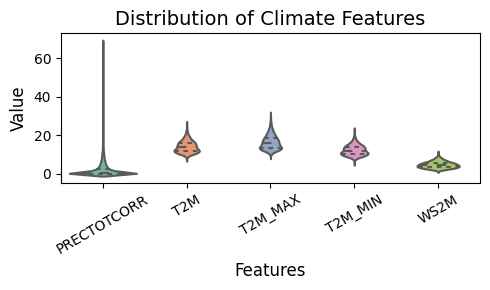

In [5]:
plot_features(features, variables, "Distribution of Climate Features")

In [6]:
normalizer = MinMaxScaler((0,1))
normalized_features = normalizer.fit_transform(features)

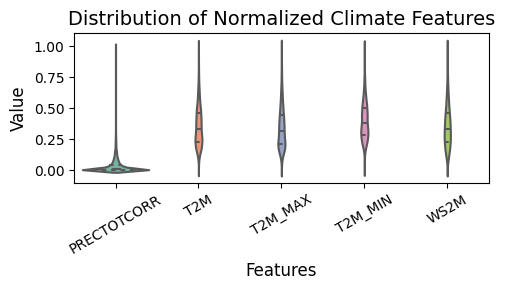

In [7]:
plot_features(normalized_features, variables, "Distribution of Normalized Climate Features")

In [8]:
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(normalized_features)

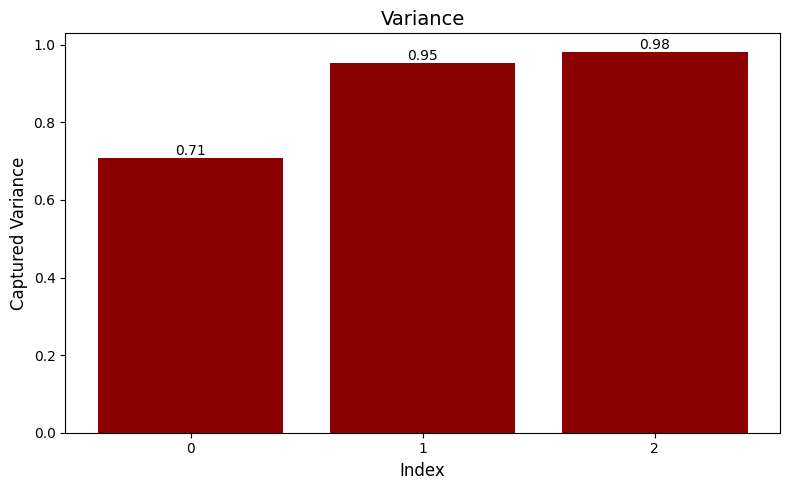

In [9]:
# variance captured by the number of components.

accumulated = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(8,5))
plt.bar(range(len(accumulated)), accumulated, color="darkred")
for i, val in enumerate(accumulated):
    plt.text(i, val , str(round(val,2)), ha='center', va='bottom', fontsize=10)
# Labels
plt.title("Variance", fontsize=14)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Captured Variance", fontsize=12)
plt.xticks(range(len(pca.explained_variance_ratio_)))

plt.tight_layout()
plt.show()

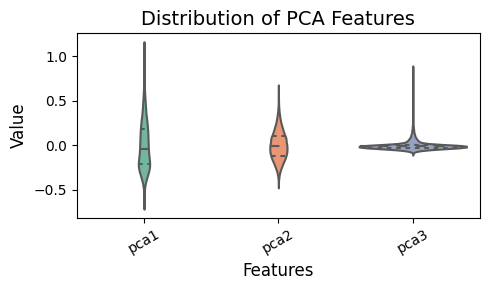

In [10]:
plot_features(reduced_features, ['pca1','pca2','pca3'], "Distribution of PCA Features")

In [11]:
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", n_jobs = -1)
model.fit(reduced_features)

TimeSeriesKMeans(metric='dtw', n_jobs=-1)

In [12]:
centers = model.predict(reduced_features)

c:\Users\abrah\AppData\Local\Programs\Python\Python311\Lib\site-packages\tslearn\utils\utils.py:108: UserWarning: 2-Dimensional data passed. Assuming these are 16071 1-dimensional timeseries
  warnings.warn(


In [473]:
df_data_seasons = pd.DataFrame(features, columns=variables)
df_data_seasons['SEASON'] = centers
df_data_seasons['DOY'] = doys
df_data_seasons['YEAR'] = years
df_data_seasons['DATE'] = pd.to_datetime(df_data_seasons["YEAR"].astype(str) + df_data_seasons["DOY"].astype(str), format="%Y%j")
df_data_seasons["month"] = df_data_seasons['DATE'].dt.month

df_data_seasons['kmeans_dtw'] =centers
data = df_data_seasons.copy()
data['seasons_kmeans'] = data.apply(lambda x:  x['kmeans_dtw'], axis=1)


C:\Users\abrah\AppData\Local\Temp\ipykernel_6712\3942386592.py:1: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(data = data, x='T2M', y='WS2M',hue='seasons_kmeans', palette=['blue','red','green','gold'])


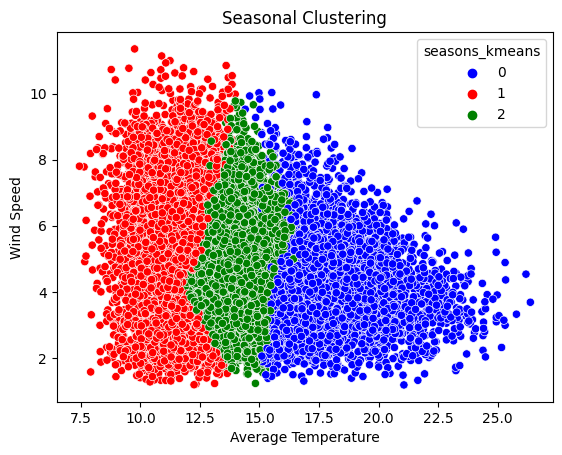

In [477]:
sns.scatterplot(data = data, x='T2M', y='WS2M',hue='seasons_kmeans', palette=['blue','red','green','gold'])
plt.title('Seasonal Clustering')
plt.xlabel('Average Temperature')
plt.ylabel('Wind Speed')
plt.show()

C:\Users\abrah\AppData\Local\Temp\ipykernel_6712\3648598938.py:1: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(data = data.loc[data.YEAR == 1998,:], x='DOY', y='T2M',hue='seasons_kmeans',palette=['blue','red','gold','green'])


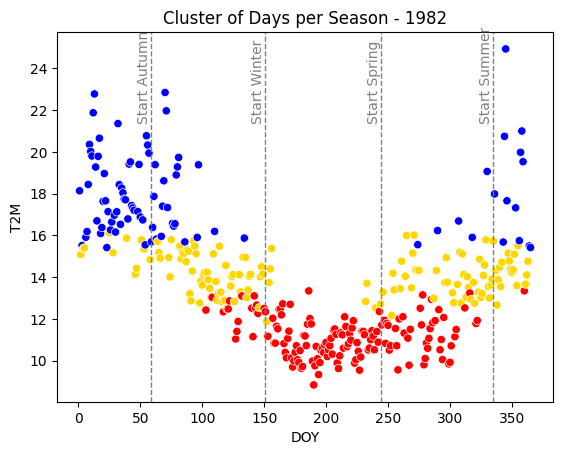

In [478]:
sns.scatterplot(data = data.loc[data.YEAR == 1998,:], x='DOY', y='T2M',hue='seasons_kmeans',palette=['blue','red','gold','green'])
plt.axvline(x=59, color='grey', linestyle='--', linewidth=1)
plt.axvline(x=151, color='grey', linestyle='--', linewidth=1)
plt.axvline(x=244, color='grey', linestyle='--', linewidth=1)
plt.axvline(x=335, color='grey', linestyle='--', linewidth=1)

ymax = data.T2M.max()  # top of the plot
offset = 1  # shift above the top

plt.text(59,  ymax-5,  "Start Autumn", ha='right', va='bottom', rotation=90, color='grey')
plt.text(151, ymax-5, "Start Winter", ha='right', va='bottom', rotation=90, color='grey')
plt.text(244, ymax-5, "Start Spring", ha='right', va='bottom', rotation=90, color='grey')
plt.text(335, ymax-5, "Start Summer", ha='right', va='bottom', rotation=90, color='grey')
plt.title('Cluster of Days per Season - 1982')
plt.legend([],[], frameon=False)
plt.show()

### Analysis of Summer

In [479]:
import pymannkendall as mk

Obteniendo los datos del summer.
Opcion -> separar los dataframes según los check points.
1. obtener los índices de los checkpoints en una lista
2. separar el dataframe desde el checkpoint presente al checkpoint futuro.
3. colocar los checkpoints en una lista


In [480]:
# when the values are bigger than 75, it is considered a different season.

summer_data = data[data.seasons_kmeans  == 0]
summer_distance = summer_data.reset_index()['index'].diff()
start_summer_index = summer_distance.index[summer_distance>75]
end_summer_index = start_summer_index-1

summer_start = summer_data.iloc[start_summer_index]['DATE'][:-1] #remove the half summers
summer_end = summer_data.iloc[end_summer_index]['DATE'][1:]
summer_duration =  pd.to_timedelta(summer_end.values - summer_start.values)

summer_middle = summer_start+summer_duration/2
#summer_distance.sort_values()[-100:].hist(bins=50)
#plt.show()


Mann_Kendall_Test(trend='increasing', h=True, p=0.02867310187384975, z=2.1879519593849204, Tau=0.23255813953488372, s=210.0, var_s=9124.666666666666, slope=0.75, intercept=199.25)


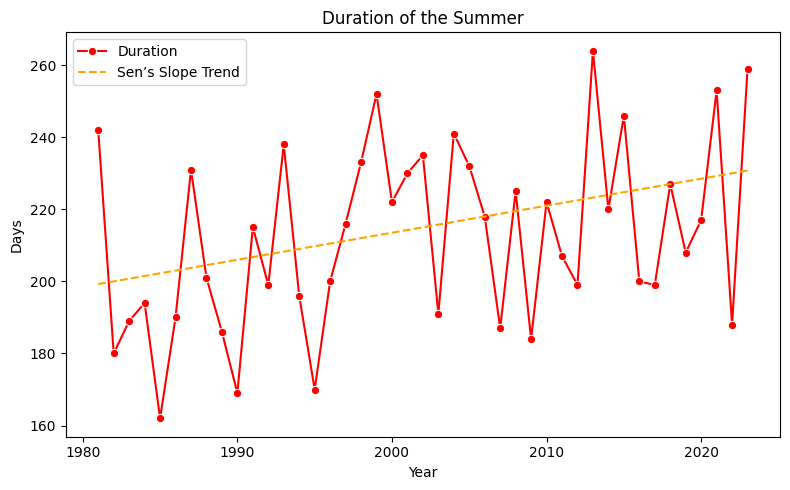

In [481]:
mk_test_duration = mk.original_test(summer_duration.days)
print(mk_test_duration)
plt.figure(figsize=(8, 5))
sns.lineplot(x=list(range(1981,2024)), y=summer_duration.days, marker="o", label=f"Duration", color = 'red')

# Add Sen’s slope line
slope = mk_test_duration.slope
intercept = mk_test_duration.intercept
trend_line = slope * np.array(range(43)) + intercept
plt.plot(list(range(1981,2024)), trend_line, color="orange", linestyle="--", label="Sen’s Slope Trend")

# Style
plt.title(f"Duration of the Summer")
plt.xlabel("Year")
plt.ylabel('Days')
plt.legend()
plt.tight_layout()
plt.show()

Mann_Kendall_Test(trend='decreasing', h=True, p=0.008827831636177397, z=-2.618650596000631, Tau=-0.2779623477297896, s=-251.0, var_s=9114.333333333334, slope=-0.5555555555555556, intercept=295.6666666666667)


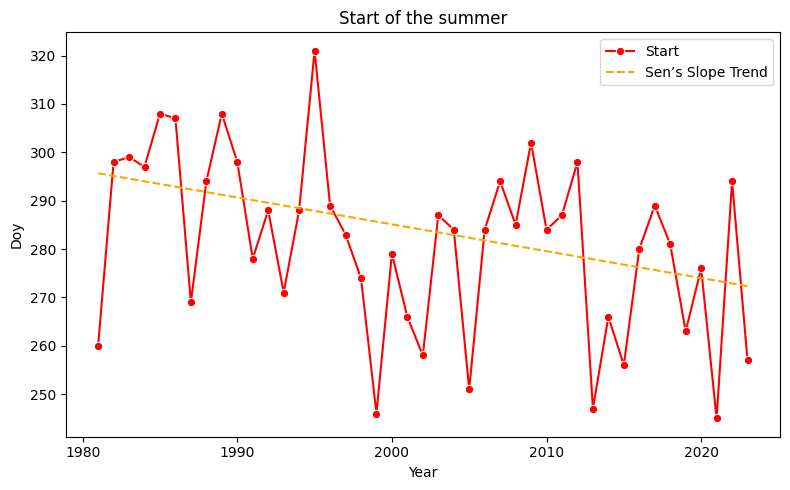

In [482]:
mk_test_start = mk.original_test(summer_start.dt.dayofyear)
print(mk_test_start)

plt.figure(figsize=(8, 5))
sns.lineplot(x=list(range(1981,2024)), y=summer_start.dt.dayofyear, marker="o", label=f"Start", color = 'red')

slope = mk_test_start.slope
intercept = mk_test_start.intercept
trend_line = slope * np.array(range(43)) + intercept
plt.plot(list(range(1981,2024)), trend_line, color="orange", linestyle="--", label="Sen’s Slope Trend")

# Style
plt.title(f"Start of the summer")
plt.xlabel("Year")
plt.ylabel('Doy')
plt.legend()
plt.tight_layout()
plt.show()

Mann_Kendall_Test(trend='no trend', h=False, p=0.41379801326489885, z=0.817228228904559, Tau=0.08748615725359911, s=79.0, var_s=9109.666666666666, slope=0.14814814814814814, intercept=125.88888888888889)


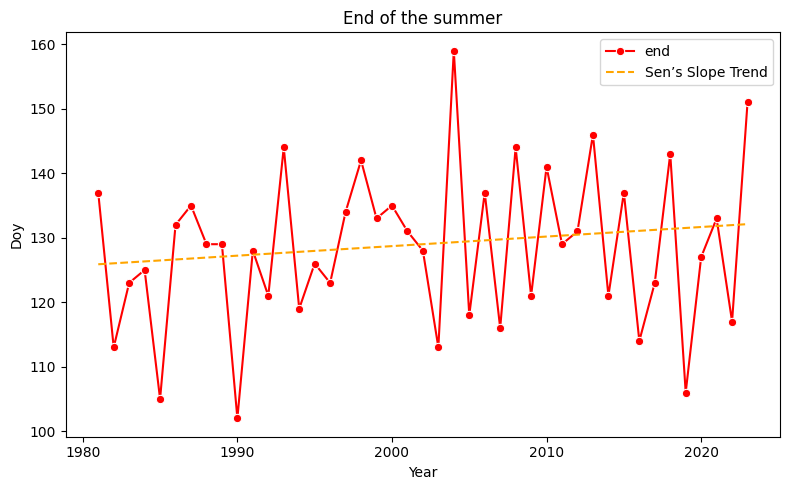

In [483]:
mk_test_end = mk.original_test(summer_end.dt.dayofyear)
print(mk_test_end)

plt.figure(figsize=(8, 5))
sns.lineplot(x=list(range(1981,2024)), y=summer_end.dt.dayofyear, marker="o", label=f"end", color = 'red')

slope = mk_test_end.slope
intercept = mk_test_end.intercept
trend_line = slope * np.array(range(43)) + intercept
plt.plot(list(range(1981,2024)), trend_line, color="orange", linestyle="--", label="Sen’s Slope Trend")
# Style
plt.title(f"End of the summer")
plt.xlabel("Year")
plt.ylabel('Doy')
plt.legend()
plt.tight_layout()
plt.show()

## Analysis of Winter

In [484]:
winter_data = data[data.seasons_kmeans  == 1]
winter_distance = winter_data.reset_index()['index'].diff()

start_winter_index = winter_distance.index[winter_distance>58].drop(2955)

end_winter_index = start_winter_index-1
# winter_distance.sort_values()[-70:].hist(bins=50)
winter_start = winter_data.iloc[pd.Index([0]).append(start_winter_index)]['DATE']
winter_end = winter_data.iloc[end_winter_index.append(pd.Index([len(winter_data)-1]))]['DATE']

winter_duration =  pd.to_timedelta(winter_end.values - winter_start.values)

winter_middle = winter_end - winter_duration/2
print(len(start_winter_index), start_winter_index)


43 Int64Index([ 141,  289,  443,  587,  729,  889, 1049, 1151, 1301, 1446, 1583,
            1754, 1902, 2065, 2256, 2427, 2576, 2721, 2832, 2956, 3061, 3183,
            3325, 3473, 3571, 3722, 3848, 3970, 4084, 4229, 4352, 4495, 4602,
            4699, 4833, 4959, 5075, 5197, 5336, 5482, 5611, 5752, 5849],
           dtype='int64')


Mann_Kendall_Test(trend='decreasing', h=True, p=0.030370265994025925, z=-2.165227517614956, Tau=-0.22727272727272727, s=-215.0, var_s=9768.333333333334, slope=-0.9180602006688963, intercept=243.23829431438128)


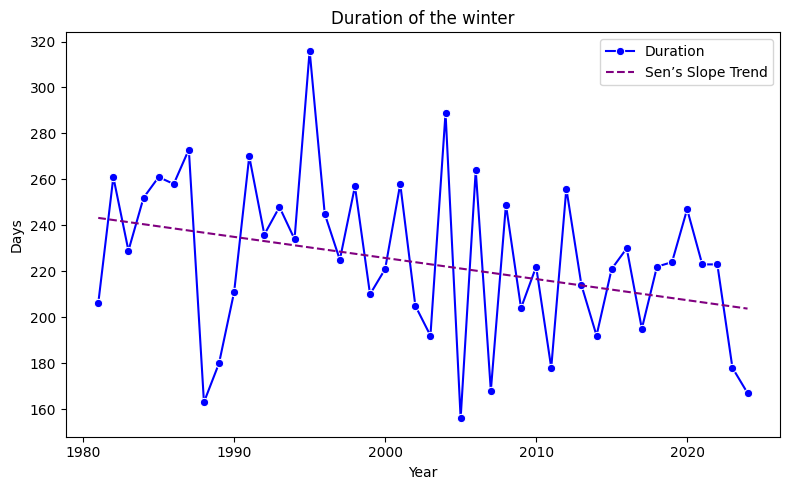

In [485]:
mk_test_duration = mk.original_test(winter_duration.days)
print(mk_test_duration)
plt.figure(figsize=(8, 5))
sns.lineplot(x=list(range(1981,2025)), y=winter_duration.days, marker="o", label=f"Duration", color = 'blue')

# Add Sen’s slope line
slope = mk_test_duration.slope
intercept = mk_test_duration.intercept
trend_line = slope * np.array(range(44)) + intercept
plt.plot(list(range(1981,2025)), trend_line, color="purple", linestyle="--", label="Sen’s Slope Trend")

# Style
plt.title(f"Duration of the winter")
plt.xlabel("Year")
plt.ylabel('Days')
plt.legend()
plt.tight_layout()
plt.show()

Mann_Kendall_Test(trend='no trend', h=False, p=0.12142907752474064, z=1.54880302763709, Tau=0.16279069767441862, s=154.0, var_s=9758.666666666666, slope=0.4, intercept=105.9)


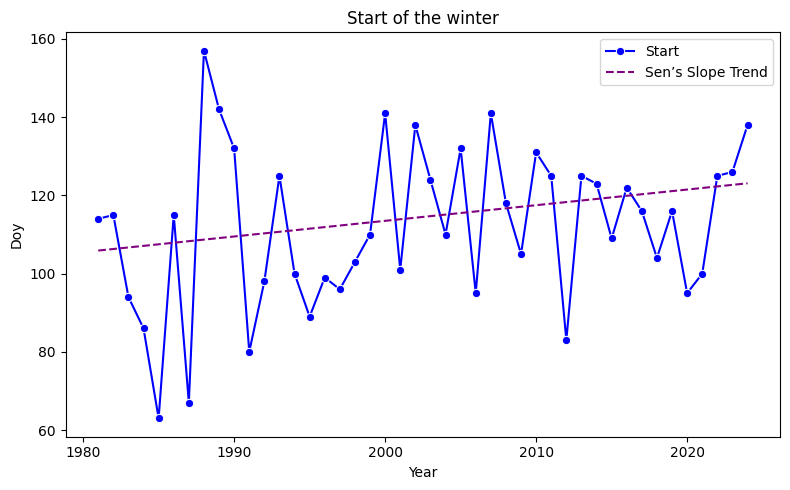

In [486]:
mk_test_start = mk.original_test(winter_start.dt.dayofyear)
print(mk_test_start)

plt.figure(figsize=(8, 5))
sns.lineplot(x=list(range(1981,2025)), y=winter_start.dt.dayofyear, marker="o", label=f"Start", color = 'blue')

slope = mk_test_start.slope
intercept = mk_test_start.intercept
trend_line = slope * np.array(range(44)) + intercept
plt.plot(list(range(1981,2025)), trend_line, color="purple", linestyle="--", label="Sen’s Slope Trend")

# Style
plt.title(f"Start of the winter")
plt.xlabel("Year")
plt.ylabel('Doy')
plt.legend()
plt.tight_layout()
plt.show()

Mann_Kendall_Test(trend='no trend', h=False, p=0.1239786767480957, z=-1.5382861004588542, Tau=-0.16173361522198731, s=-153.0, var_s=9763.666666666666, slope=-0.4337979094076655, intercept=347.8266550522648)


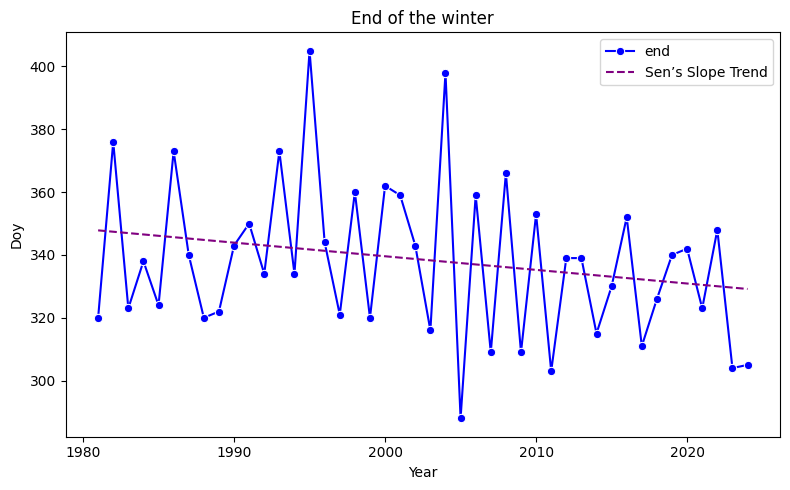

In [487]:
mk_test_end = mk.original_test(winter_end.dt.dayofyear.apply(lambda x: x+365 if x<200 else x))
print(mk_test_end)

plt.figure(figsize=(8, 5))
sns.lineplot(x=list(range(1981,2025)), y=winter_end.dt.dayofyear.apply(lambda x: x+365 if x<200 else x), marker="o", label=f"end", color = 'blue')

slope = mk_test_end.slope
intercept = mk_test_end.intercept
trend_line = slope * np.array(range(44)) + intercept
plt.plot(list(range(1981,2025)), trend_line, color="purple", linestyle="--", label="Sen’s Slope Trend")
# Style
plt.title(f"End of the winter")
plt.xlabel("Year")
plt.ylabel('Doy')
plt.legend()
plt.tight_layout()
plt.show()

Fall

In [488]:
data['season_flag']=None
for summer_middle_date, winter_middle_date in zip(summer_middle, winter_middle):
    data.loc[data.DATE==pd.Timestamp(summer_middle_date.date()), 'season_flag'] = 'fall'
    data.loc[data.DATE==pd.Timestamp(winter_middle_date.date()), 'season_flag'] = 'spring'
data.loc[data.DATE==pd.Timestamp(winter_middle.iloc[-1].date()), 'season_flag'] = 'spring'
data.season_flag.ffill(inplace=True)
data.season_flag.fillna('fall',inplace=True)


In [489]:
data['seasons_kmeans'] = data.apply(lambda x:  3 if (x['kmeans_dtw']==2) & (x['season_flag']== 'fall') else x['kmeans_dtw'], axis = 1)

In [490]:
fall_data = data[data.seasons_kmeans  == 3]
fall_distance = fall_data.reset_index()['index'].diff()

start_fall_index = fall_distance.index[fall_distance>100]

end_fall_index = start_fall_index-1
#fall_distance.sort_values()[-70:].hist(bins=50)
fall_start = fall_data.iloc[pd.Index([0]).append(start_fall_index)]['DATE']
fall_end = fall_data.iloc[end_fall_index.append(pd.Index([len(fall_data)-1]))]['DATE']

fall_duration =  pd.to_timedelta(fall_end.values - fall_start.values)

fall_middle = fall_end - fall_duration/2
print(len(start_fall_index), start_fall_index)

43 Int64Index([  52,  106,  161,  229,  273,  339,  404,  468,  515,  564,  656,
             719,  789,  856,  907,  966, 1024, 1089, 1155, 1218, 1303, 1369,
            1441, 1516, 1591, 1640, 1682, 1757, 1835, 1881, 1944, 1987, 2052,
            2116, 2181, 2238, 2303, 2349, 2412, 2483, 2557, 2597, 2668],
           dtype='int64')


Mann_Kendall_Test(trend='no trend', h=False, p=0.09700304603159382, z=1.659559775665954, Tau=0.1744186046511628, s=165.0, var_s=9765.666666666666, slope=0.6306818181818181, intercept=162.4403409090909)


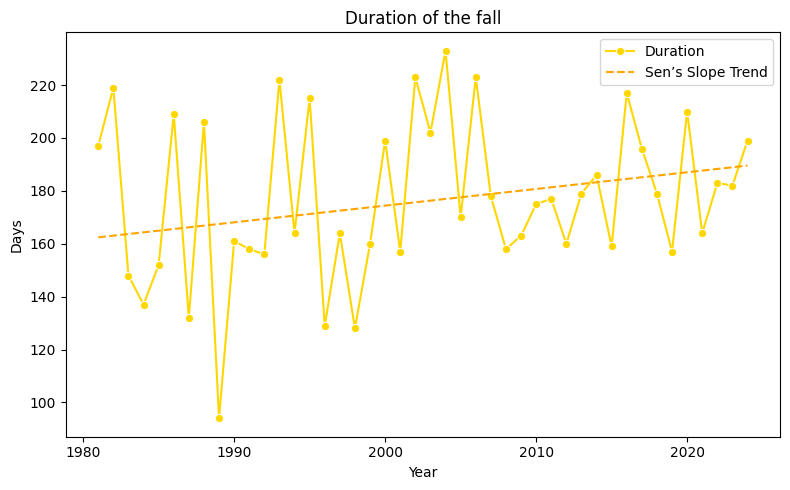

In [491]:
mk_test_duration = mk.original_test(fall_duration.days)
print(mk_test_duration)
plt.figure(figsize=(8, 5))
sns.lineplot(x=list(range(1981,2025)), y=fall_duration.days, marker="o", label=f"Duration", color = 'gold')

# Add Sen’s slope line
slope = mk_test_duration.slope
intercept = mk_test_duration.intercept
trend_line = slope * np.array(range(44)) + intercept
plt.plot(list(range(1981,2025)), trend_line, color="orange", linestyle="--", label="Sen’s Slope Trend")

# Style
plt.title(f"Duration of the fall")
plt.xlabel("Year")
plt.ylabel('Days')
plt.legend()
plt.tight_layout()
plt.show()


Mann_Kendall_Test(trend='no trend', h=False, p=0.471673447016113, z=-0.7197589118608184, Tau=-0.07610993657505286, s=-72.0, var_s=9730.666666666666, slope=-0.12310606060606061, intercept=29.646780303030305)


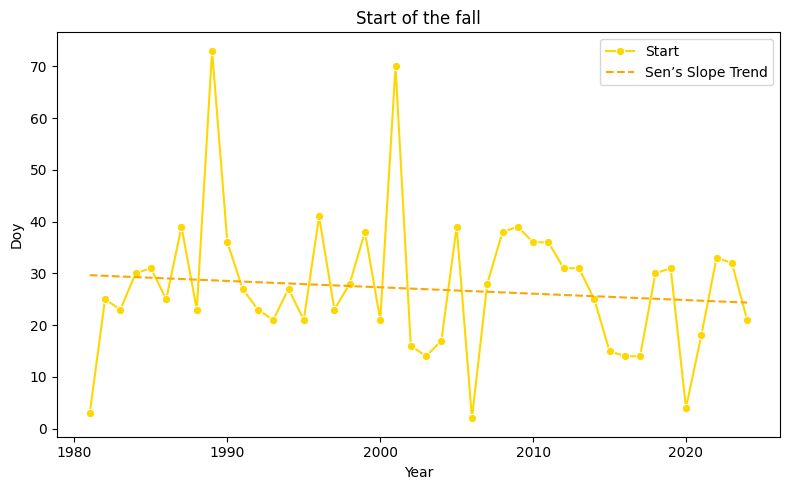

In [492]:
mk_test_start = mk.original_test(fall_start.dt.dayofyear)
print(mk_test_start)

plt.figure(figsize=(8, 5))
sns.lineplot(x=list(range(1981,2025)), y=fall_start.dt.dayofyear, marker="o", label=f"Start", color = 'gold')

slope = mk_test_start.slope
intercept = mk_test_start.intercept
trend_line = slope * np.array(range(44)) + intercept
plt.plot(list(range(1981,2025)), trend_line, color="orange", linestyle="--", label="Sen’s Slope Trend")

# Style
plt.title(f"Start of the fall")
plt.xlabel("Year")
plt.ylabel('Doy')
plt.legend()
plt.tight_layout()
plt.show()


Mann_Kendall_Test(trend='no trend', h=False, p=0.21701350821476995, z=1.2345084278359129, Tau=0.13002114164904863, s=123.0, var_s=9766.333333333334, slope=0.4142156862745098, intercept=200.09436274509804)


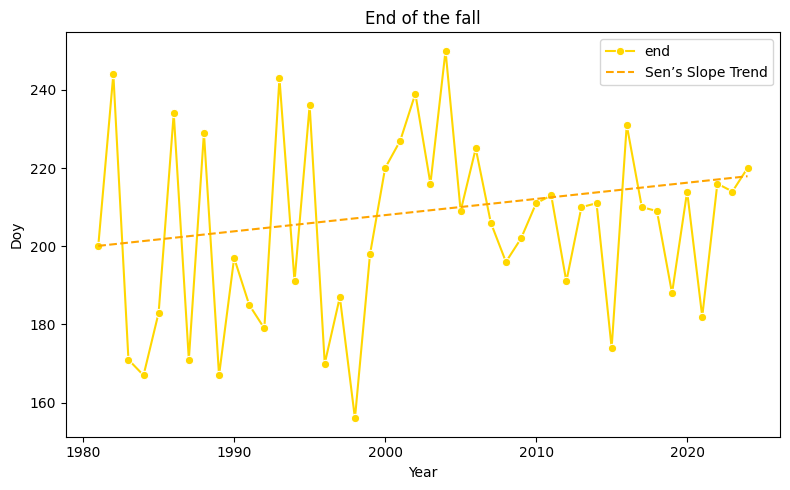

In [493]:

mk_test_end = mk.original_test(fall_end.dt.dayofyear)
print(mk_test_end)

plt.figure(figsize=(8, 5))
sns.lineplot(x=list(range(1981,2025)), y=fall_end.dt.dayofyear, marker="o", label=f"end", color = 'gold')

slope = mk_test_end.slope
intercept = mk_test_end.intercept
trend_line = slope * np.array(range(44)) + intercept
plt.plot(list(range(1981,2025)), trend_line, color="orange", linestyle="--", label="Sen’s Slope Trend")
# Style
plt.title(f"End of the fall")
plt.xlabel("Year")
plt.ylabel('Doy')
plt.legend()
plt.tight_layout()
plt.show()

In [494]:
spring_data = data[data.seasons_kmeans  == 2]
spring_distance = spring_data.reset_index()['index'].diff()

start_spring_index = spring_distance.index[spring_distance>100]

end_spring_index = start_spring_index-1
#spring_distance.sort_values()[-70:].hist(bins=50)
spring_start = spring_data.iloc[pd.Index([0]).append(start_spring_index)]['DATE']
spring_end = spring_data.iloc[end_spring_index.append(pd.Index([len(spring_data)-1]))]['DATE']

spring_duration =  pd.to_timedelta(spring_end.values - spring_start.values)

spring_middle = spring_end - spring_duration/2
print(len(start_spring_index), start_spring_index)

43 Int64Index([  60,  116,  175,  242,  317,  382,  427,  509,  561,  610,  680,
             727,  793,  833,  894,  952, 1004, 1073, 1150, 1200, 1279, 1342,
            1388, 1444, 1509, 1573, 1632, 1705, 1766, 1820, 1889, 1946, 2023,
            2088, 2135, 2190, 2239, 2293, 2335, 2397, 2460, 2516, 2585],
           dtype='int64')


Mann_Kendall_Test(trend='no trend', h=False, p=0.34641900911425294, z=0.9415579458077199, Tau=0.09936575052854123, s=94.0, var_s=9756.0, slope=0.15384615384615385, intercept=139.19230769230768)


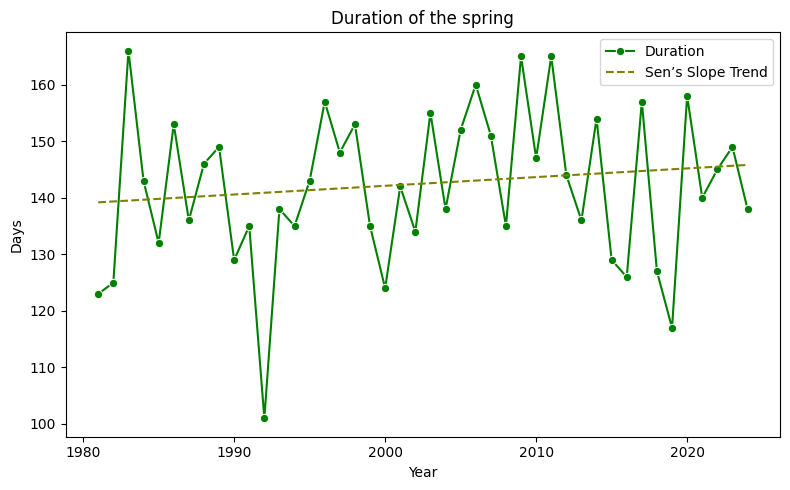

In [495]:

mk_test_duration = mk.original_test(spring_duration.days)
print(mk_test_duration)
plt.figure(figsize=(8, 5))
sns.lineplot(x=list(range(1981,2025)), y=spring_duration.days, marker="o", label=f"Duration", color = 'green')

# Add Sen’s slope line
slope = mk_test_duration.slope
intercept = mk_test_duration.intercept
trend_line = slope * np.array(range(44)) + intercept
plt.plot(list(range(1981,2025)), trend_line, color="olive", linestyle="--", label="Sen’s Slope Trend")

# Style
plt.title(f"Duration of the spring")
plt.xlabel("Year")
plt.ylabel('Days')
plt.legend()
plt.tight_layout()
plt.show()


Mann_Kendall_Test(trend='decreasing', h=True, p=0.002068966364944691, z=-3.080149611662195, Tau=-0.3224101479915433, s=-305.0, var_s=9741.0, slope=-0.5, intercept=248.75)


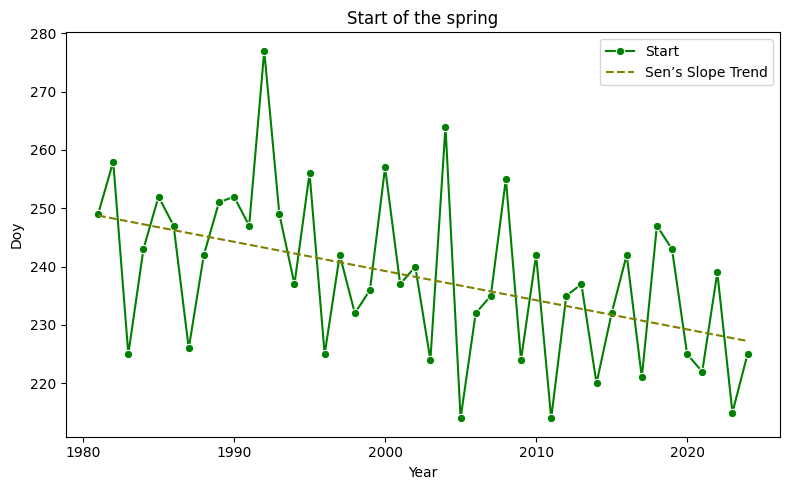

In [496]:
mk_test_start = mk.original_test(spring_start.dt.dayofyear)
print(mk_test_start)

plt.figure(figsize=(8, 5))
sns.lineplot(x=list(range(1981,2025)), y=spring_start.dt.dayofyear, marker="o", label=f"Start", color = 'green')

slope = mk_test_start.slope
intercept = mk_test_start.intercept
trend_line = slope * np.array(range(44)) + intercept
plt.plot(list(range(1981,2025)), trend_line, color="olive", linestyle="--", label="Sen’s Slope Trend")

# Style
plt.title(f"Start of the spring")
plt.xlabel("Year")
plt.ylabel('Doy')
plt.legend()
plt.tight_layout()
plt.show()

Mann_Kendall_Test(trend='decreasing', h=True, p=0.004440868998231373, z=-2.845019602866681, Tau=-0.29809725158562367, s=-282.0, var_s=9755.333333333334, slope=-0.38675213675213677, intercept=388.81517094017096)


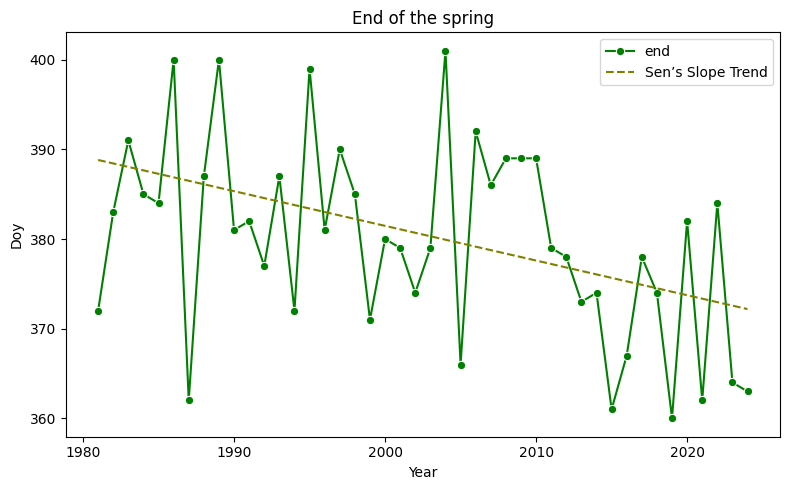

In [497]:

mk_test_end = mk.original_test(spring_end.dt.dayofyear.apply(lambda x: x+365 if x<200 else x))
print(mk_test_end)

plt.figure(figsize=(8, 5))
sns.lineplot(x=list(range(1981,2025)), y=spring_end.dt.dayofyear.apply(lambda x: x+365 if x<200 else x), marker="o", label=f"end", color = 'green')

slope = mk_test_end.slope
intercept = mk_test_end.intercept
trend_line = slope * np.array(range(44)) + intercept
plt.plot(list(range(1981,2025)), trend_line, color="olive", linestyle="--", label="Sen’s Slope Trend")
# Style
plt.title(f"End of the spring")
plt.xlabel("Year")
plt.ylabel('Doy')
plt.legend()
plt.tight_layout()
plt.show()

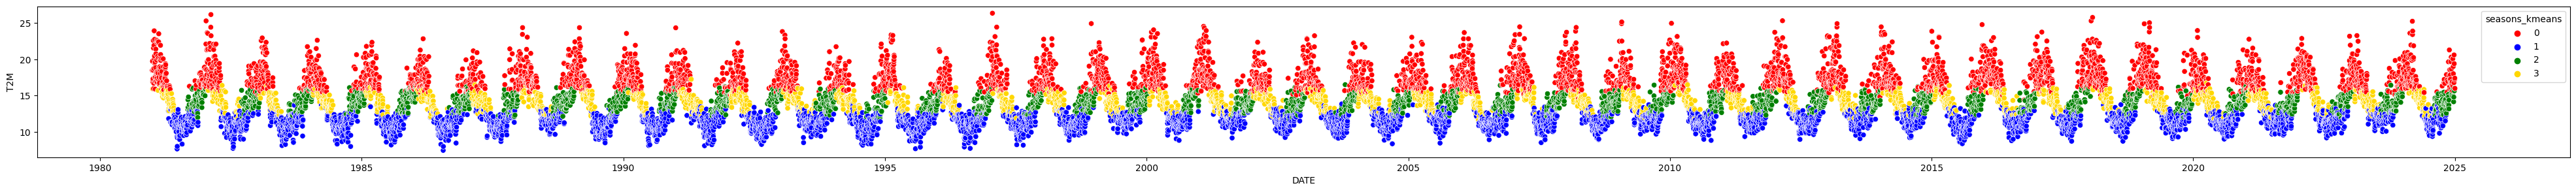

In [506]:
plt.figure(figsize=(50,3))
sns.scatterplot(data = data, x='DATE' ,y='T2M',hue='seasons_kmeans',palette=['red','blue','green','gold'])
# plt.vlines(spring_end, ymin=10, ymax = 30)
# plt.vlines(spring_start, ymin=10, ymax = 30)
plt.show()

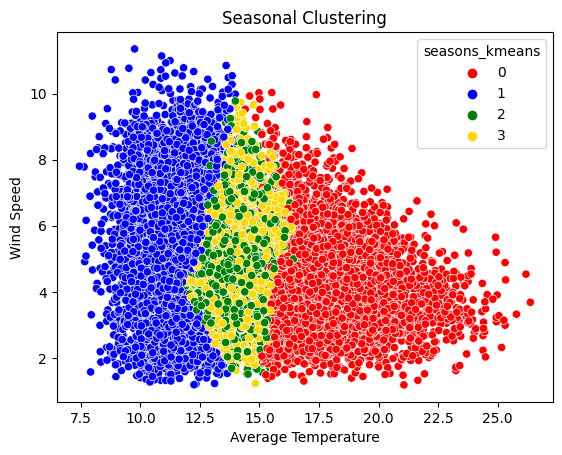

In [504]:
sns.scatterplot(data = data, x='T2M', y='WS2M',hue='seasons_kmeans', palette=['red','blue','green','gold'])
plt.title('Seasonal Clustering')
plt.xlabel('Average Temperature')
plt.ylabel('Wind Speed')
plt.show()


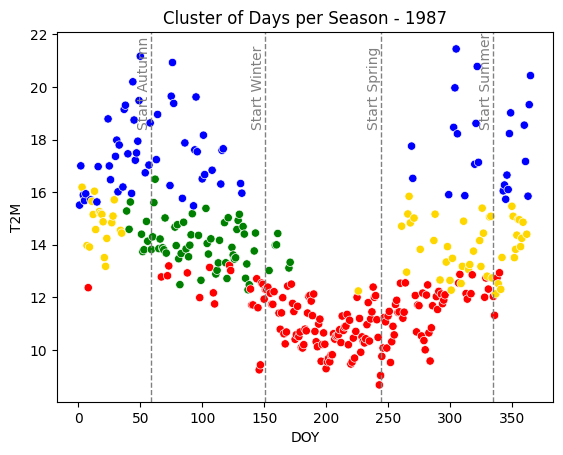

In [519]:
sns.scatterplot(data = data.loc[data.YEAR == 1987,:], x='DOY', y='T2M',hue='seasons_kmeans',palette=['blue','red','gold','green'])
plt.axvline(x=59, color='grey', linestyle='--', linewidth=1)
plt.axvline(x=151, color='grey', linestyle='--', linewidth=1)
plt.axvline(x=244, color='grey', linestyle='--', linewidth=1)
plt.axvline(x=335, color='grey', linestyle='--', linewidth=1)

ymax = data.T2M.max()  # top of the plot
offset = 1  # shift above the top

plt.text(59,  ymax-8,  "Start Autumn", ha='right', va='bottom', rotation=90, color='grey')
plt.text(151, ymax-8, "Start Winter", ha='right', va='bottom', rotation=90, color='grey')
plt.text(244, ymax-8, "Start Spring", ha='right', va='bottom', rotation=90, color='grey')
plt.text(335, ymax-8, "Start Summer", ha='right', va='bottom', rotation=90, color='grey')
plt.title('Cluster of Days per Season - 1987')
plt.legend([],[], frameon=False)
plt.show()

Other experiments

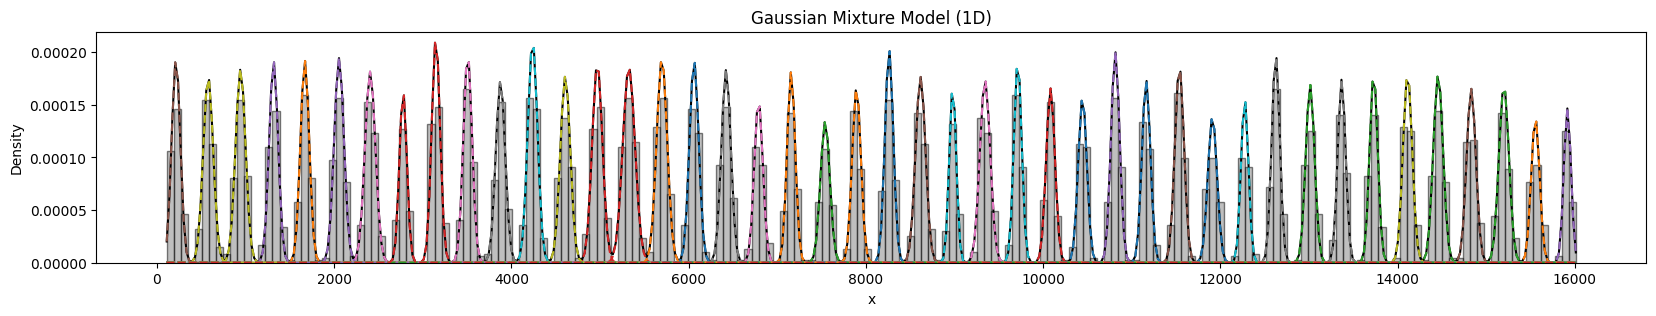

In [500]:
from sklearn.mixture import GaussianMixture

# Example: replace with your numbers

from scipy.stats import norm

# Example data
x = winter_data.index.values.reshape(-1, 1)

# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=44, random_state=3).fit(x)

# Plot histogram of the data
plt.figure(figsize=(20,3))
plt.hist(x, bins=200, density=True, alpha=0.5, color="gray", edgecolor="black")

# Create a range of values to evaluate the PDFs
x_range = np.linspace(x.min() - 1, x.max() + 1, 500).reshape(-1, 1)

# Overall mixture density
logprob = gmm.score_samples(x_range)
pdf = np.exp(logprob)
plt.plot(x_range, pdf, "-k", label="Mixture")

# Individual components
for mean, cov, weight in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    std = np.sqrt(cov[0][0])  # standard deviation
    component_pdf = weight * norm.pdf(x_range, mean[0], std)
    plt.plot(x_range, component_pdf, "--", label=f"Component μ={mean[0]:.2f}")

#plt.legend()
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Gaussian Mixture Model (1D)")
plt.show()

In [501]:
weights = gmm.weights_              # mixture weights (sum to 1)
means = gmm.means_.ravel()          # means of each Gaussian
variances = gmm.covariances_.ravel()  # variances of each Gaussian

print("Weights:", weights)
print("Means:", means.max())
print("Variances:", variances)

Weights: [0.02391373 0.02391016 0.02054563 0.0274487  0.02441886 0.02172441
 0.02441922 0.02441886 0.02595926 0.02121927 0.01801957 0.02088199
 0.02121928 0.03206446 0.01498821 0.02374524 0.02694299 0.02307138
 0.02340829 0.01650447 0.01919887 0.01633544 0.02458768 0.02526103
 0.02694724 0.02408215 0.0186933  0.02256652 0.02490088 0.02879764
 0.02509066 0.02054569 0.02374547 0.02054516 0.02425305 0.02492365
 0.02542945 0.01953519 0.02491791 0.01633545 0.0207142  0.02890881
 0.01768313 0.01717749]
Means: 15915.067415810407
Variances: [2221.45855453 2469.98331795 2091.32007262 3351.99483403 2369.67624065
 2753.21239082 2432.61776737 2829.87143725 3176.41480696 1957.74117107
 2683.14683636 2109.193051   2507.81876727 4753.75179798 1665.47860128
 2403.62791508 3507.21956647 2847.05606189 2718.9301528  1552.21592557
 2377.64930872 2260.82145058 3019.58884966 2224.31241984 3060.51407597
 2659.84104072 2347.1491312  2076.74968046 3175.82621465 2985.48829655
 2720.44709467 2432.55268929 3176.1